In this notebook I will re-fit the free parameters of the Krisciunas & Schaefer (1991) moon model using BOSS sky fiber data. The free parameters I will be fitting are $C_R$, $C_{M,0}$, $C_{M,1}$ of the scattering function $f(\rho)$. 

__Krisciunas & Schaefer (1991)__ model
$$B_\mathrm{moon} = f(\rho) I^* 10^{-0.4 k\,X(Z_m)} [1 - 10^{-0.4 k\,X(Z)}]$$
where
$$f(\rho) = f_R(\rho) + f_M(\rho) = C_R [1.06 + cos^2(\rho)] + 10^{C_{M,0} - \rho/C_{M,1}}$$

Original values for the parameters are 

$C_R = 10^{5.36}$, $C_{M,0} = 6.15$, and $C_{M,1} = 40.$. 

In [8]:
import pickle
import numpy as np 
import scipy.optimize as sciop
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter
# -- astropy -- 
import astropy.units as u
from astropy.table import Table as aTable
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Lets read in the BOSS sky fluxes and their corresponding meta data

In [3]:
boss_blue = aTable.read(''.join([UT.dat_dir(), 'sky/', 'Bright_BOSS_Sky_blue.fits']))

(0.0, 1.0)

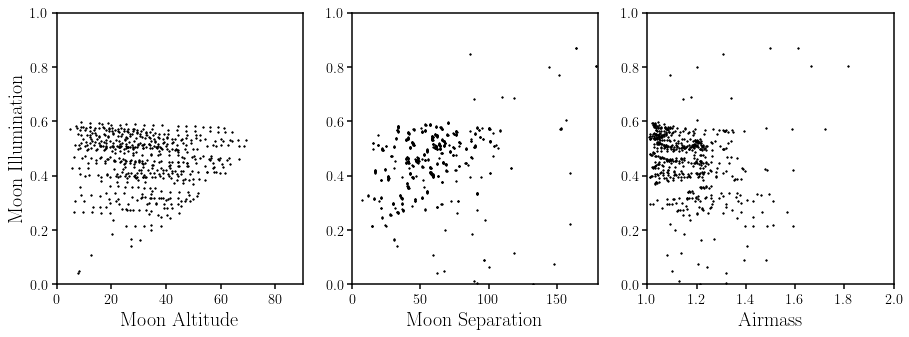

In [4]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_blue['MOON_ALT'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0., 1.])
sub = fig.add_subplot(132)
sub.scatter(boss_blue['MOON_SEP'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([0., 180.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(133)
sub.scatter(boss_blue['AIRMASS'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0., 1.])

The plot above illustrates the limitations of directly using the BOSS sky model for BGS. There's no sky data when moon illumination is $> 0.6$.

In [5]:
specsim_sky = Sky.specsim_initialize('desi')
specsim_wave = specsim_sky._wavelength # Ang

cr_def = specsim_sky.moon.KS_CR
cm0_def = specsim_sky.moon.KS_CM0
cm1_def = specsim_sky.moon.KS_CM1
print('Original C_R = %f, C_M0 = %f, C_M1 = %f' % (cr_def, cm0_def, cm1_def))

Original C_R = 229086.765277, C_M0 = 6.150000, C_M1 = 40.000000


/anaconda2/lib/python2.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [6]:
def KS_sky(airmass, moonill, moonalt, moonsep, cr, cm0, cm1): 
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = cr
    specsim_sky.moon.KS_CM0 = cm0 
    specsim_sky.moon.KS_CM1 = cm1 
    return specsim_sky.surface_brightness

Lets compare BOSS sky surface brightnesses to the default UVES + KS sky brightness

Text(0.5,0,'wavelength')

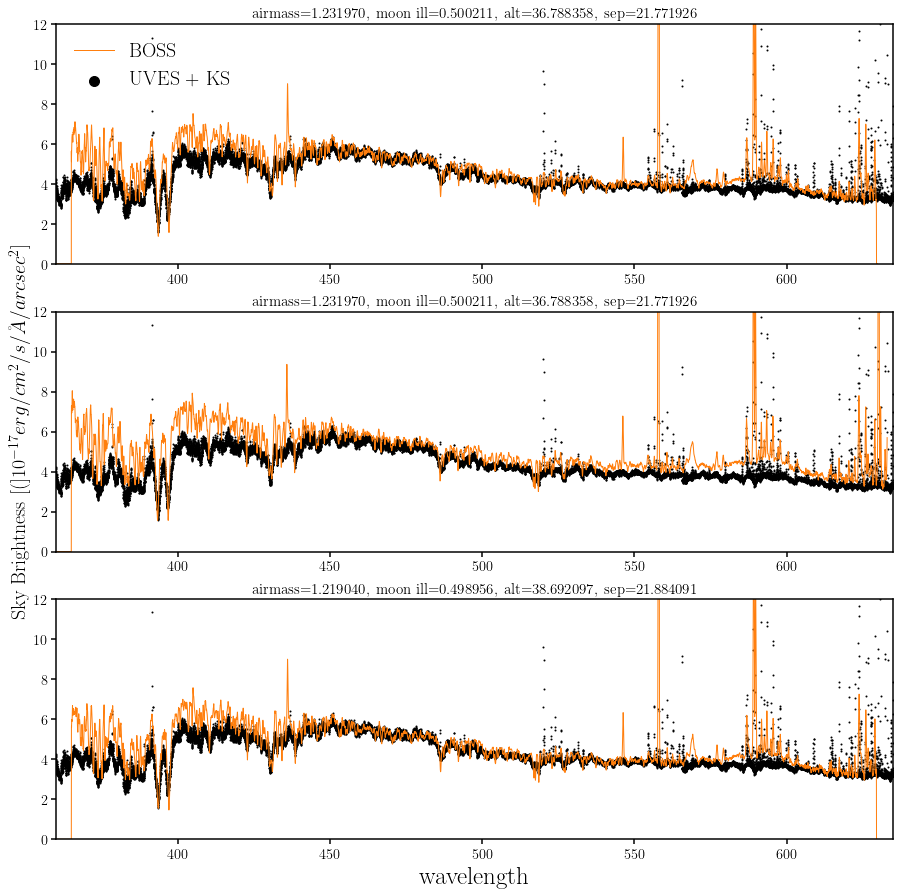

In [7]:
fig = plt.figure(figsize=(15,15))
for ii, i in enumerate([0, 1, 2]):#np.random.choice(range(len(blue_skyavg)), 3, replace=False)):
    # get the UVES + KS sky given observing parameters
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr_def, cm0_def, cm1_def)
    sub = fig.add_subplot(3,1,ii+1)
    sub.plot(boss_blue['WAVE'][i], boss_blue['SKY'][i]/np.pi, lw=1, c='C1', label='BOSS')
    sub.scatter(specsim_wave/10., ks_i, s=1, c='k', label='UVES + KS')
    sub.set_xlim([360., 635])
    if ii == 0: sub.legend(loc='upper left', markerscale=10, fontsize=20)
    if ii == 1: 
        sub.set_ylabel('Sky Brightness [(]$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    sub.set_ylim([0., 12])
    sub.set_title(('airmass=%f, moon ill=%f, alt=%f, sep=%f' % (boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])), fontsize=15)
sub.set_xlabel('wavelength', fontsize=25)

Lets focus on the sky brightness at a specific blue wavelength that's not too noisy: $4100A$. 

In [9]:
boss_skycont380 = pickle.load(open(''.join([UT.dat_dir(), 'sky/Bright_BOSS_Sky_blue380.p']), 'rb'))
boss_skycont410 = pickle.load(open(''.join([UT.dat_dir(), 'sky/Bright_BOSS_Sky_blue410.p']), 'rb'))
boss_skycont460 = pickle.load(open(''.join([UT.dat_dir(), 'sky/Bright_BOSS_Sky_blue460.p']), 'rb'))

In [10]:
wls, emfluxes = [], [] 
for n in ['346', '437', '580L', '580U', '800U', '860L', '860U']: 
    f = ''.join([UT.code_dir(), 'dat/sky/UVES_ident/', 'gident_', n, '.dat'])
    wl, emfwhm, emflux = np.loadtxt(open(f, 'rt').readlines()[:-1], skiprows=3, unpack=True, usecols=[1, 3, 4])
    wls.append(wl)
    emfluxes.append(emflux)
wls = np.concatenate(wls)
emfluxes = np.concatenate(emfluxes)
keep = (emfluxes > 0.5) & (wls >= 3600.) & (wls <= 10400.)

def line_mask(wave): # wavelenght in angstrom 
    lines_mask = np.ones(len(wave)).astype(bool)
    for w in wls[keep]: 
        nearline = ((wave > w * n_edlen(w) - 5.) & (wave < w * n_edlen(w) + 5.))
        lines_mask = lines_mask & ~nearline

    lamp = np.array([4047, 4048, 4165, 4168, 4358, 4420, 4423, 4665, 4669, 4827, 
                     4832, 4983, 5461, 5683, 5688, 5770, 5791, 5893, 6154, 6161]) 
    for w in lamp: 
        nearline = ((wave > w - 5) & (wave < w + 5.))
        lines_mask = lines_mask & ~nearline
    return lines_mask

In [11]:
def n_edlen(ll): 
    return 1. + 10**-8 * (8432.13 + 2406030./(130.-(1/ll)**2) + 15977/(38.9 - (1/ll)**2))

In [12]:
ks_wlim380 = ((specsim_wave.value > 3600.) & (specsim_wave.value < 4000.))
ks_wlim410 = ((specsim_wave.value > 3900.) & (specsim_wave.value < 4300.))
ks_wlim460 = ((specsim_wave.value > 4400.) & (specsim_wave.value < 4800.))
ks_linemask = line_mask(specsim_wave.value)

In [13]:
ks_skycont380 = np.zeros(len(boss_blue))
ks_skycont410 = np.zeros(len(boss_blue))
ks_skycont460 = np.zeros(len(boss_blue))
for i in range(len(boss_blue)): 
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr_def, cm0_def, cm1_def)
    #ks_i_cont = gaussian_filter(medfilt(ks_i.value, 51), 100)
    ks_skycont380[i] = np.median(gaussian_filter(medfilt(ks_i.value[ks_wlim380 & ks_linemask], 21), 80))   
    ks_skycont410[i] = np.median(gaussian_filter(medfilt(ks_i.value[ks_wlim410 & ks_linemask], 21), 80))   
    ks_skycont460[i] = np.median(gaussian_filter(medfilt(ks_i.value[ks_wlim460 & ks_linemask], 21), 80))   

Text(0.5,0,'wavelength')

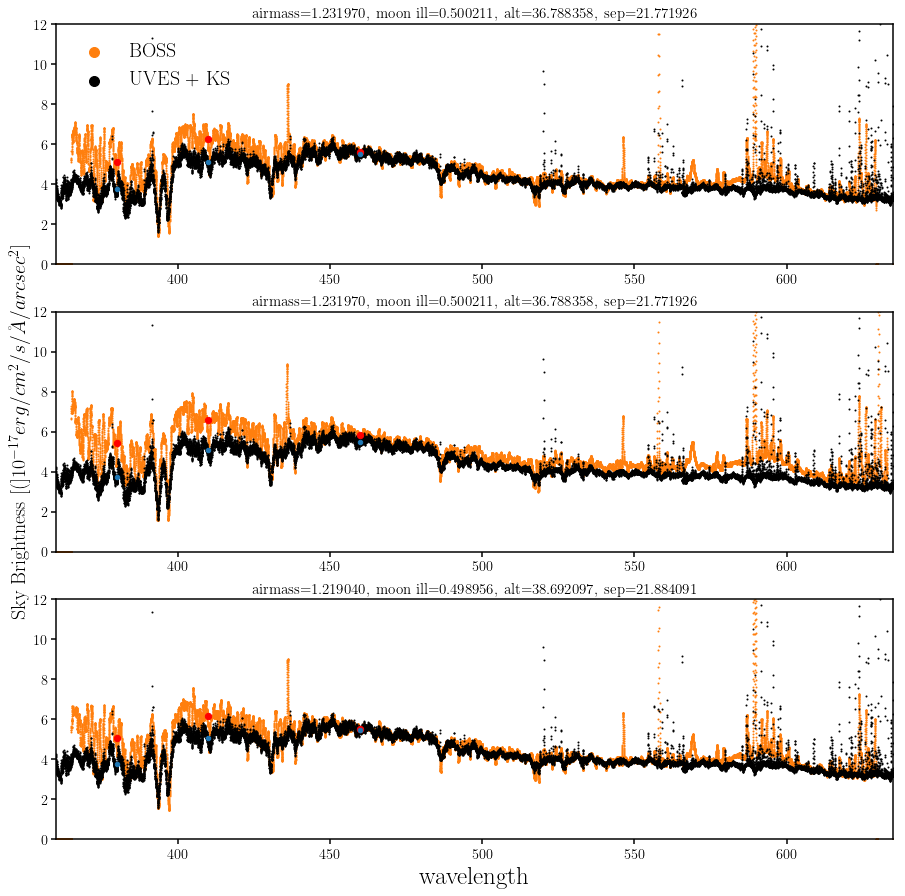

In [19]:
fig = plt.figure(figsize=(15,15))
for ii, i in enumerate([0, 1, 2]):#np.random.choice(range(len(blue_skyavg)), 3, replace=False)):
    # get the UVES + KS sky given observing parameters
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr_def, cm0_def, cm1_def)
    sub = fig.add_subplot(3,1,ii+1)
    sub.scatter(boss_blue['WAVE'][i], boss_blue['SKY'][i]/np.pi, s=1, c='C1', label='BOSS')
    sub.scatter(specsim_wave/10., ks_i, s=1, c='k', label='UVES + KS')
    sub.scatter([380, 410, 460], [boss_skycont380[i], boss_skycont410[i], boss_skycont460[i]], c='r', s=40)
    sub.scatter([380, 410, 460], [ks_skycont380[i], ks_skycont410[i], ks_skycont460[i]], c='C0', s=20)
    sub.set_xlim([360., 635])
    if ii == 0: sub.legend(loc='upper left', markerscale=10, fontsize=20)
    if ii == 1: 
        sub.set_ylabel('Sky Brightness [(]$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    sub.set_ylim([0., 12])
    sub.set_title(('airmass=%f, moon ill=%f, alt=%f, sep=%f' % (boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])), fontsize=15)
sub.set_xlabel('wavelength', fontsize=25)

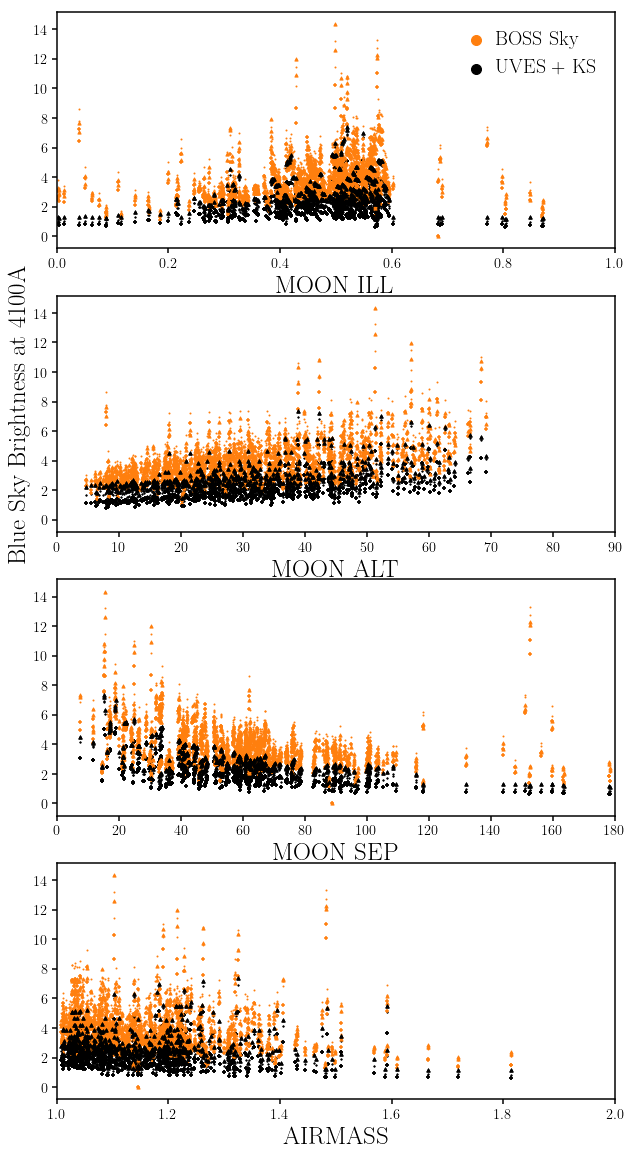

In [20]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_skycont410, c='C1', s=1, label='BOSS Sky')
    sub.scatter(boss_blue[k], ks_skycont410, c='k', s=1, label='UVES + KS')
    sub.scatter(boss_blue[k], boss_skycont380, marker='+', c='C1', s=10)
    sub.scatter(boss_blue[k], ks_skycont380, marker='+', c='k', s=10)
    sub.scatter(boss_blue[k], boss_skycont460, marker='^', c='C1', s=10)
    sub.scatter(boss_blue[k], ks_skycont460, marker='^', c='k', s=10)
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('Blue Sky Brightness at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])

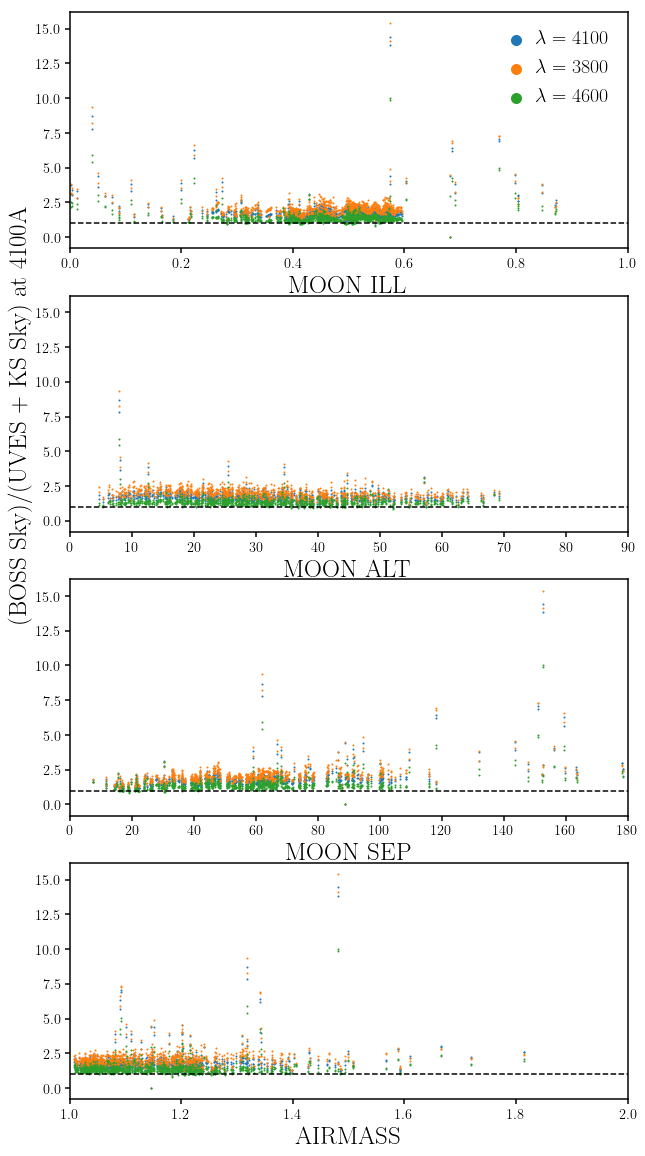

In [21]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_skycont410/ks_skycont410, c='C0', s=1, label='$\lambda = 4100$')
    sub.scatter(boss_blue[k], boss_skycont380/ks_skycont380, c='C1', s=1, label='$\lambda = 3800$')
    sub.scatter(boss_blue[k], boss_skycont460/ks_skycont460, c='C2', s=1, label='$\lambda = 4600$')
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('(BOSS Sky)/(UVES + KS Sky) at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])
    sub.plot(sub.get_xlim(), [1., 1.], color='k', linestyle='--')

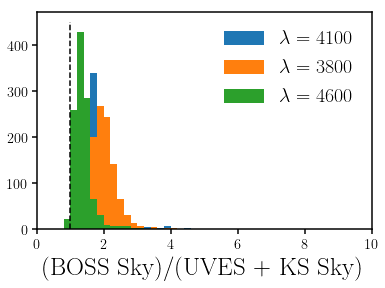

In [22]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(boss_skycont410/ks_skycont410, range=(0., 20.), bins=100, label='$\lambda = 4100$')
sub.hist(boss_skycont380/ks_skycont380, range=(0., 20.), bins=100, label='$\lambda = 3800$')
sub.hist(boss_skycont460/ks_skycont460, range=(0., 20.), bins=100, label='$\lambda = 4600$')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('(BOSS Sky)/(UVES + KS Sky)', fontsize=25)
sub.set_xlim([0., 10.])
#sub.set_yscale("log")
_, ymax = sub.get_ylim()
sub.vlines(1., 0, ymax, color='k', linestyle='--')

Now lets use the newly fit $C_R$, $C_{M,0}$, and $C_{M,1}$ to better reproduce the sky brightness continuum at $3800, 4100, 4600 A$

In [40]:
#cr_new, cm0_new, cm1_new = 10**5.66103, 5.596972, 118.8776
cr_new, cm0_new, cm1_new = 10**5.661030, 5.540103, 178.141045

In [41]:
print('Default C_R = 10^%f, C_M0 = %f, C_M1 = %f' % (np.log10(cr_def), cm0_def, cm1_def))
print('New C_R = 10^%f, C_M0 = %f, C_M1 = %f' % (np.log10(cr_new), cm0_new, cm1_new))

Default C_R = 10^5.360000, C_M0 = 6.150000, C_M1 = 40.000000
New C_R = 10^5.661030, C_M0 = 5.540103, C_M1 = 178.141045


In [42]:
ks_new_skycont380 = np.zeros(len(boss_blue))
ks_new_skycont410 = np.zeros(len(boss_blue))
ks_new_skycont460 = np.zeros(len(boss_blue))
for i in range(len(boss_blue)): 
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr_new, cm0_new, cm1_new)
    ks_new_skycont380[i] = np.median(gaussian_filter(medfilt(ks_i.value[ks_wlim380 & ks_linemask], 21), 100))   
    ks_new_skycont410[i] = np.median(gaussian_filter(medfilt(ks_i.value[ks_wlim410 & ks_linemask], 21), 100))     
    ks_new_skycont460[i] = np.median(gaussian_filter(medfilt(ks_i.value[ks_wlim460 & ks_linemask], 21), 100))    

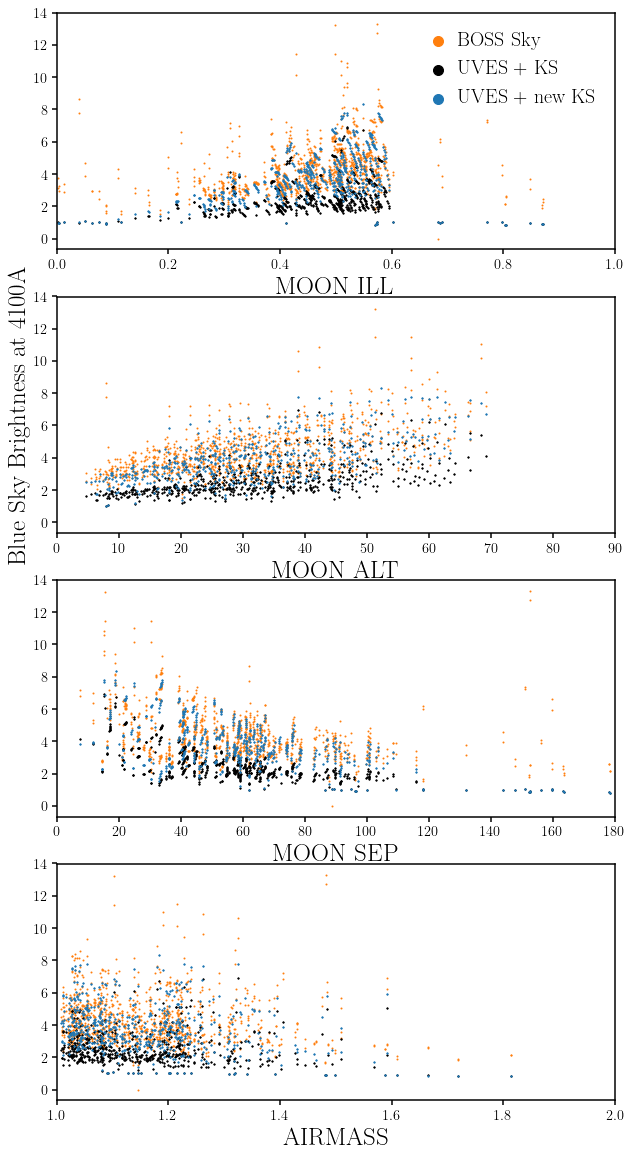

In [43]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_skycont410, c='C1', s=1, label='BOSS Sky')
    sub.scatter(boss_blue[k], ks_skycont410, c='k', s=1, label='UVES + KS')
    sub.scatter(boss_blue[k], ks_new_skycont410, c='C0', s=1, label='UVES + new KS')
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('Blue Sky Brightness at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])

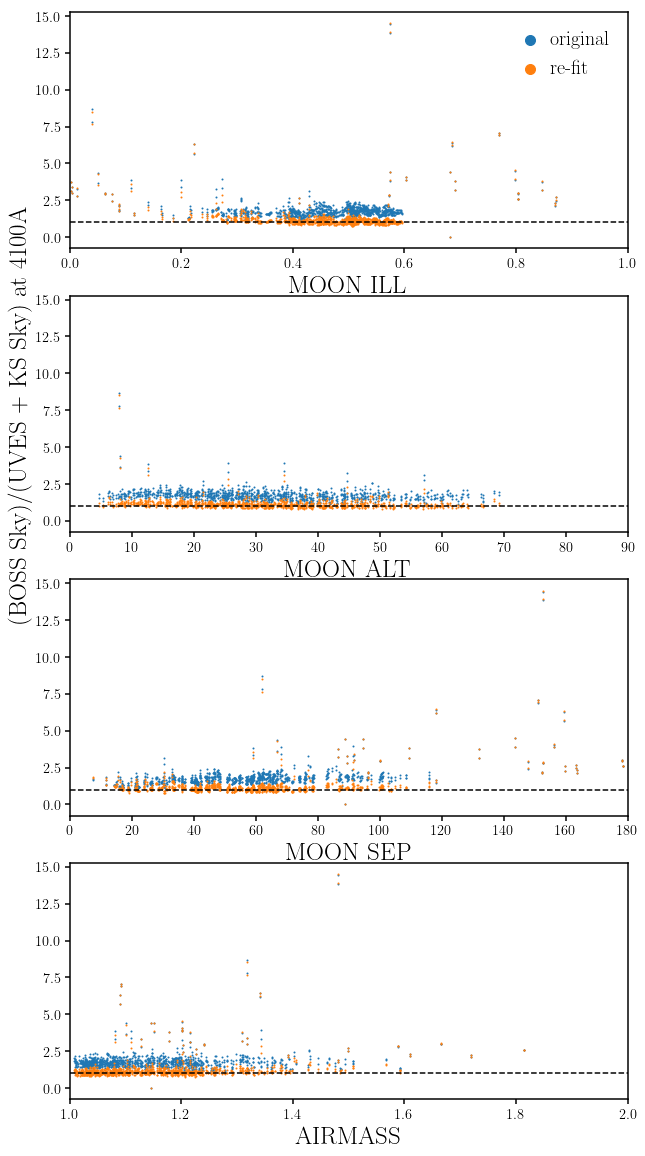

In [44]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_skycont410 / ks_skycont410, c='C0', s=1, label='original')
    sub.scatter(boss_blue[k], boss_skycont410 / ks_new_skycont410, c='C1', s=1, label='re-fit')
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('(BOSS Sky)/(UVES + KS Sky) at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])
    sub.plot(sub.get_xlim(), [1., 1.], color='k', linestyle='--')

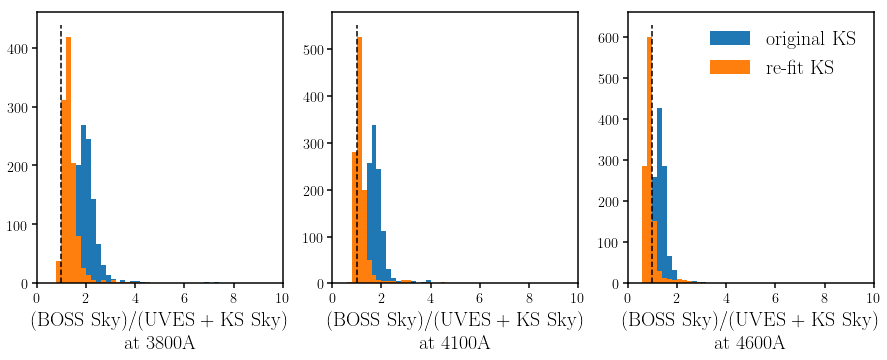

In [45]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.hist(boss_skycont380/ks_skycont380, range=(0., 20.), bins=100, label='original KS')
sub.hist(boss_skycont380/ks_new_skycont380, range=(0., 20.), bins=100, label='re-fit KS')
#sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('(BOSS Sky)/(UVES + KS Sky) \n at 3800A', fontsize=20
              )
sub.set_xlim([0., 10.])
_, ymax = sub.get_ylim()
sub.vlines(1., 0, ymax, color='k', linestyle='--')

sub = fig.add_subplot(132)
sub.hist(boss_skycont410/ks_skycont410, range=(0., 20.), bins=100, label='original KS')
sub.hist(boss_skycont410/ks_new_skycont410, range=(0., 20.), bins=100, label='re-fit KS')
#sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('(BOSS Sky)/(UVES + KS Sky) \n at 4100A', fontsize=20)
sub.set_xlim([0., 10.])
#sub.set_yscale("log")
_, ymax = sub.get_ylim()
sub.vlines(1., 0, ymax, color='k', linestyle='--')

sub = fig.add_subplot(133)
sub.hist(boss_skycont460/ks_skycont460, range=(0., 20.), bins=100, label='original KS')
sub.hist(boss_skycont460/ks_new_skycont460, range=(0., 20.), bins=100, label='re-fit KS')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('(BOSS Sky)/(UVES + KS Sky) \n at 4600A', fontsize=20)
sub.set_xlim([0., 10.])
#sub.set_yscale("log")
_, ymax = sub.get_ylim()
sub.vlines(1., 0, ymax, color='k', linestyle='--')

Text(0.5,0,'wavelength')

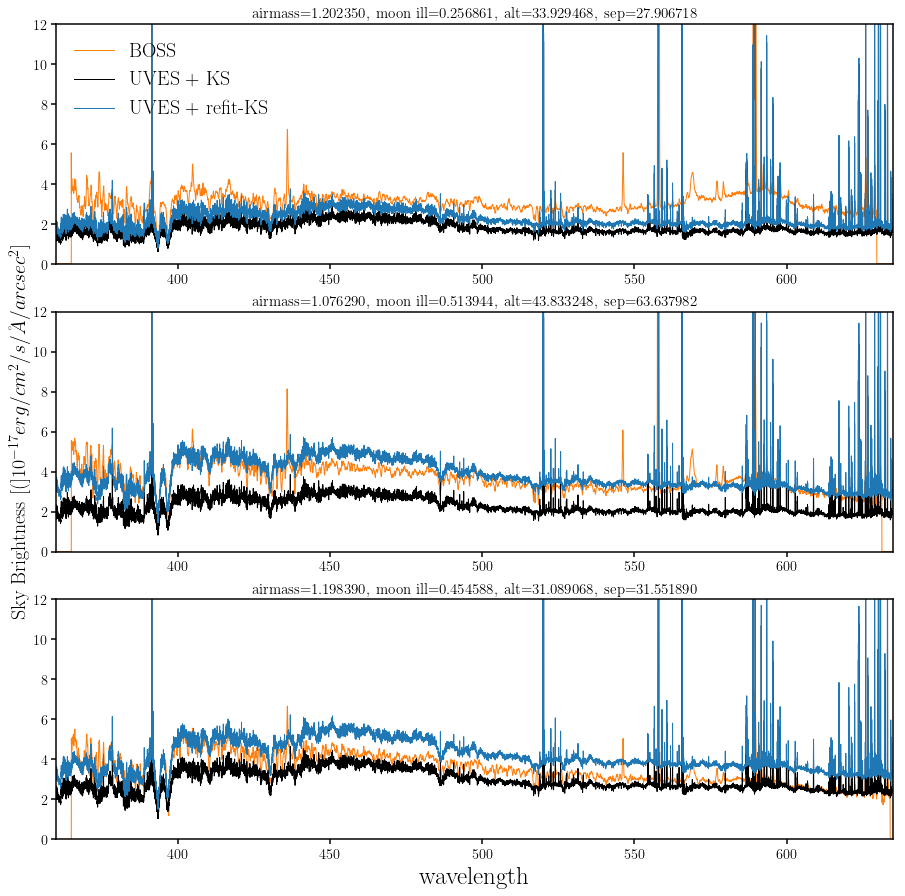

In [52]:
low_sun = (boss_blue['SUN_ALT'] < -20.)

fig = plt.figure(figsize=(15,15))
for ii, i in enumerate(np.random.choice(np.arange(len(boss_blue))[low_sun], 3, replace=False)):
    # get the UVES + KS sky given observing parameters
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr_def, cm0_def, cm1_def)
    ks_new_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr_new, cm0_new, cm1_new)
    
    sub = fig.add_subplot(3,1,ii+1)
    sub.plot(boss_blue['WAVE'][i], boss_blue['SKY'][i]/np.pi, lw=1, c='C1', label='BOSS')
    sub.plot(specsim_wave/10., ks_i, lw=1, c='k', label='UVES + KS')
    sub.plot(specsim_wave/10., ks_new_i, lw=1, c='C0', label='UVES + refit-KS')

    sub.set_xlim([360., 635])
    if ii == 0: sub.legend(loc='upper left', markerscale=10, fontsize=20)
    if ii == 1: 
        sub.set_ylabel('Sky Brightness [(]$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    sub.set_ylim([0., 12])
    sub.set_title(('airmass=%f, moon ill=%f, alt=%f, sep=%f' % (boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])), fontsize=15)
sub.set_xlabel('wavelength', fontsize=25)

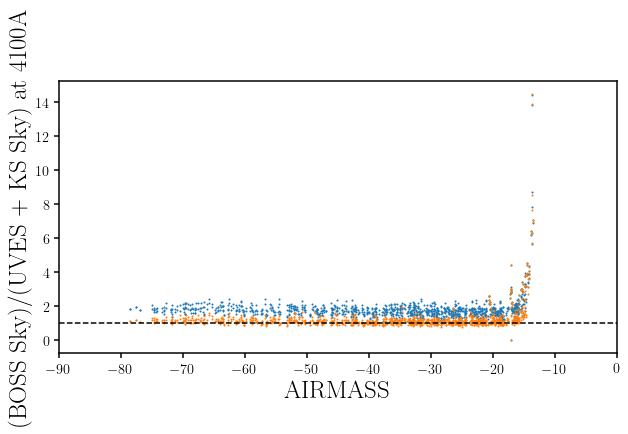

In [47]:
fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
sub.scatter(boss_blue['SUN_ALT'], boss_skycont410 / ks_skycont410, c='C0', s=1, label='original')
sub.scatter(boss_blue['SUN_ALT'], boss_skycont410 / ks_new_skycont410, c='C1', s=1, label='re-fit')
sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
sub.set_xlim([-90., 0.])
sub.set_ylabel('(BOSS Sky)/(UVES + KS Sky) at 4100A', fontsize=25)
sub.plot(sub.get_xlim(), [1., 1.], color='k', linestyle='--')

Text(0.5,0,'wavelength')

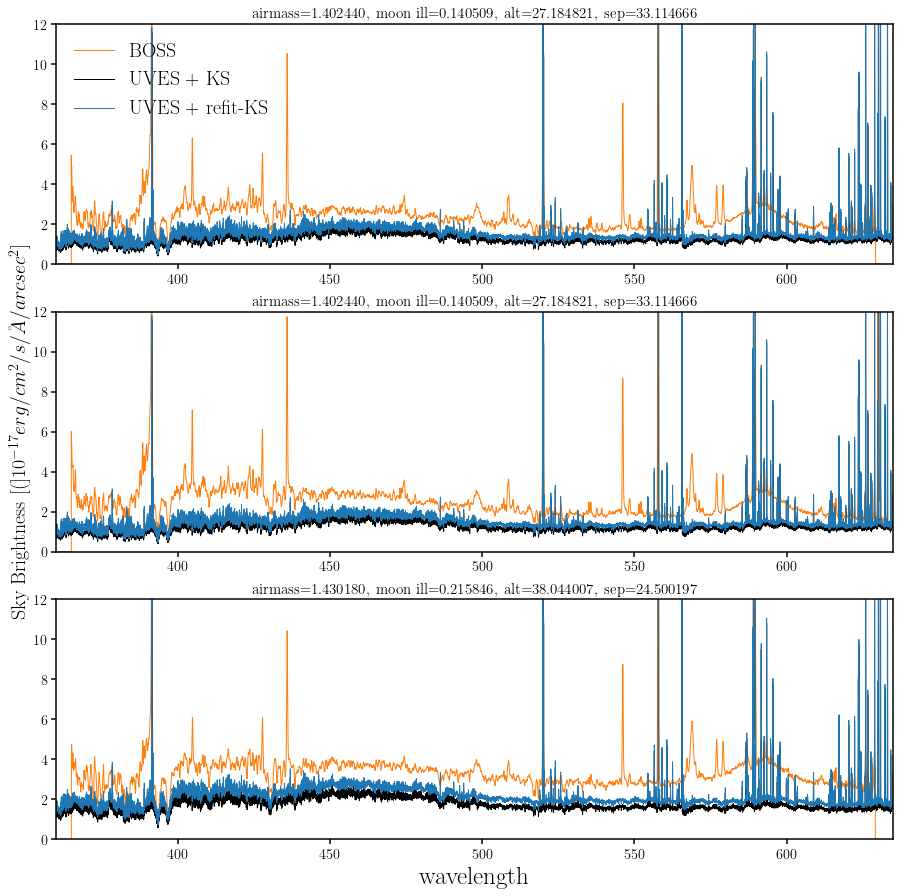

In [49]:
high_sun = (boss_blue['SUN_ALT'] > -18.)

fig = plt.figure(figsize=(15,15))
for ii, i in enumerate(np.arange(len(boss_blue))[high_sun][:3]):
    # get the UVES + KS sky given observing parameters
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr_def, cm0_def, cm1_def)
    ks_new_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], 
                  cr_new, cm0_new, cm1_new)
    
    sub = fig.add_subplot(3,1,ii+1)
    sub.plot(boss_blue['WAVE'][i], boss_blue['SKY'][i]/np.pi, lw=1, c='C1', label='BOSS')
    sub.plot(specsim_wave/10., ks_i, lw=1, c='k', label='UVES + KS')
    sub.plot(specsim_wave/10., ks_new_i, lw=1, c='C0', label='UVES + refit-KS')

    sub.set_xlim([360., 635])
    if ii == 0: sub.legend(loc='upper left', markerscale=10, fontsize=20)
    if ii == 1: 
        sub.set_ylabel('Sky Brightness [(]$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    sub.set_ylim([0., 12])
    sub.set_title(('airmass=%f, moon ill=%f, alt=%f, sep=%f' % (boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])), fontsize=15)
sub.set_xlabel('wavelength', fontsize=25)